# 输入数据处理

## 合并od_dis_table

## 生成od_count

In [50]:
import random
from datetime import date, timedelta
import pandas as pd

# 定义数据范围
random.seed(0)

od_cnt = 50500  # 共生成多少种od
# 假设您的概率列表是一个名为 o_prob 的 DataFrame，包含 "index" 和 "probability" 两列
o_prob = pd.read_csv('input/O_prob.csv')
# 重构 O_values
O_values = random.choices(o_prob["station_id"], o_prob["prob"], k=od_cnt)
# 重构 D_values
D_values = random.choices(o_prob["station_id"], o_prob["prob"], k=od_cnt)
# 重构 prob
prob = random.choices(o_prob["prob"], k=od_cnt)

# 创建 DataFrame
od3 = pd.DataFrame({
    "O": O_values,
    "D": D_values,
    "prob": prob
})
od3 = od3[od3["O"] != od3["D"]]
od3 = od3.groupby(["O", "D"]).size().reset_index(name="count")
od3['date'] = date(2023, 9, 3)

od3.to_csv('input/od_3.csv')
print(f'总共有agent:{od3["count"].sum()}')
od3

总共有agent:50307


,O,D,count,date
0,0,1,1,2023-09-03
1,0,3,2,2023-09-03
2,0,4,5,2023-09-03
3,0,5,2,2023-09-03
4,0,6,1,2023-09-03
...,...,...,...,...
33707,366,315,1,2023-09-03
33708,366,337,1,2023-09-03
33709,366,345,1,2023-09-03
33710,366,349,1,2023-09-03


## 生成trip_id

In [51]:
import csv
import random

# agent_data = pd.read_csv('input/od_origin.csv')
random.seed(0)
agent_data = pd.read_csv('input/od_3.csv')
prob = pd.read_csv('input/prob.csv')

# 生成 trip_id 列
trip_ids = []
for _, row in agent_data.iterrows():
    o = row['O']
    d = row['D']
    count = row['count']
    date = row['date']

    for i in range(1, count + 1):
        trip_id = f"{i}-{o}-{d}"
        trip_ids.append(trip_id)

agent_data = pd.DataFrame(trip_ids, columns=['trip_id'])
agent_data['O'] = agent_data['trip_id'].apply(lambda x: int(x.split('-')[1]))
agent_data['D'] = agent_data['trip_id'].apply(lambda x: int(x.split('-')[2]))
agent_data['date'] = date
start_steps = random.choices(prob["step"], prob["step_prob"], k=agent_data.shape[0])
agent_data['start_step'] = start_steps
agent_data['id'], _ = pd.factorize(agent_data['trip_id'])

# 重新排列列的顺序
agent_data = agent_data[['trip_id', 'id', 'O', 'D', 'date', 'start_step']]

agent_data.to_csv('input/od_to_trip_id2.csv')

agent_data

,trip_id,id,O,D,date,start_step
0,1-0-1,0,0,1,2023-09-03,243
1,1-0-3,1,0,3,2023-09-03,227
2,2-0-3,2,0,3,2023-09-03,151
3,1-0-4,3,0,4,2023-09-03,115
4,2-0-4,4,0,4,2023-09-03,174
...,...,...,...,...,...,...
50302,1-366-315,50302,366,315,2023-09-03,285
50303,1-366-337,50303,366,337,2023-09-03,238
50304,1-366-345,50304,366,345,2023-09-03,107
50305,1-366-349,50305,366,349,2023-09-03,254


# 代理类

In [ ]:
import random
import time
import ast
import geopandas as gpd
import pandas as pd

# 记录开始时间
start_time = time.time()
print(f'start_time:{start_time}')
time_list = []
time_list.append(start_time)


class CarAgent:

    def __init__(self, trip_id, o, d,
                 edge_ids,
                 cumsum_lengths,
                 start_step,
                 allstep,
                 energy_consumption_per_step,
                 charging_amount_per_step,
                 speed,
                 init_charge,
                 find_station_dis,  # 低于这个距离代表可以直接进入充电状态，否则继续行驶
                 charging_threshold,
                 max_charging_threshold,  # 充电到高于这个电量就开始行驶
                 date):

        # 和初始化相关的参数
        self.trip_id = trip_id
        self.o = o
        self.d = d
        self.edge_ids = edge_ids,
        self.cumsum_lengths = cumsum_lengths,
        # step
        self.allstep = allstep  # 该代理模拟的步数
        self.step = 0
        self.start_step = start_step  # 暂定为每个step代表15min
        # state
        self.energy_consumption_per_step = energy_consumption_per_step
        self.charging_amount_per_step = charging_amount_per_step
        self.date = date  # 日期
        self.charge = init_charge  # 初始电量,以后取一个正太分布
        self.speed = speed  # 每一个step能走多少距离 单位是km
        self.find_station_dis = find_station_dis  # 多近充电站可以直接去 单位m
        self.charging_threshold = charging_threshold  # 充电阈值，低于阈值开始进入寻找充电站的函数
        self.max_charging_threshold = max_charging_threshold  # 充电阈值，大于阈值离开充电站

        # other parameters
        self.current_node = o
        self.destination_node = d
        self.state = 1  # 1是行驶中，0是充电中
        self.current_edge_id = -1  # 当前所处的边ID
        self.edge_index = 0  # 记录当前行驶的边在边列表中的索引
        self.current_position_on_edge = 0  # 记录当前行驶边的累计长度
        self.current_sum_length = 0  # 记录当前行驶边长度
        # df
        self.car_df = self.create_car_dataframe()

    # utils
    def charging_per_step(self, station_agent):
        if self.charge < 85 and self.state == 0:
            self.charge += charging_amount_per_step
            station_agent.charging_demand += charging_amount_per_step
            if self.charge > 100:  # 减去多充的电
                station_agent.charging_demand -= self.charge - 100
                self.charge = 100
        else:
            self.state = 1

    def create_car_dataframe(self):
        if self.current_node == self.d:
            remain = 0
        else:
            remain = max(0, self.current_sum_length - self.current_position_on_edge)
        output_data = {
            'trip_id': self.trip_id,
            'step': self.step,
            'start_step': self.start_step,
            'current_charge': self.charge,
            'current_edge_id': self.current_edge_id,
            'remaining_length': remain,
            'current_node': self.current_node,
            'current_state': self.state,
            'date': self.date
        }
        return pd.DataFrame([output_data])

    # 选择可以直接去的充电站，find_station_dis即可认为是当前edge_id有充电站
    def find_nearby_charging_stations(self):
        return edge_to_charge[
            (edge_to_charge['edge_id'] == self.current_edge_id) &
            (edge_to_charge['charge_node_distance'] <= self.find_station_dis)
            ].sort_values('charge_node_distance')

    # 寻找最近的充电站
    def charge_at_nearest_station(self, nearby_charging_stations):
        nearest_charging_station = nearby_charging_stations.iloc[0]
        charge_node_id = nearest_charging_station['charge_node_id']
        charging_station = station_agents_dict[charge_node_id]

        # 强制充电
        if self.charge < 20 or self.charge < self.energy_consumption_per_step or charging_station.has_capacity():
            self.current_node = charge_node_id
            charging_station.station_run(self)

    # 判断是否充电
    def check_charging_station(self):
        # 行驶中
        if self.state == 1:
            if self.current_node != self.d:
                if self.charge <= 0:  # cont. 结束这个模拟，并给出报错
                    self.charge = 0
                    # print(f"{self.trip_id}'s charge is null")

                if self.charge <= self.charging_threshold:
                    nearby_charging_stations = self.find_nearby_charging_stations()
                    if not nearby_charging_stations.empty:
                        self.charge_at_nearest_station(nearby_charging_stations)
                    # else:  # 当前edge没有在find_dis距离内的充电站
                    #     print(f'{self.trip_id}在{self.current_edge_id}没找到充电站,当前电量是{self.charge}')
            else:
                # car_in_highway.pop(self.trip_id, None)
                cars_to_delete[self.trip_id] = car


    def move_to_next_node(self):
        if self.state == 1:  # and self.charge > 0:  # 行驶中;有bug，之前默认为汽车电量低会进入强制充电。当step过大，电量耗尽时汽车所在边可能没有充电站，此时进入灵车状态
            # 如果没行驶到终点
            if self.current_node != self.d:
                self.current_edge_id = self.edge_ids[0][self.edge_index]  # 更新当前所处的边ID
                self.current_position_on_edge += self.speed  # 更新当前边上的位置  有bug 汽车的距离应该不直接和step挂钩，而是和耗电多少挂钩
                self.charge = max(self.charge - self.energy_consumption_per_step, 0)  # 模拟行驶耗电量
                self.current_sum_length = self.cumsum_lengths[0][self.edge_index]
                # 如果当前边的位置 >= 路的总长度,如果没超过也得更新position
                if self.current_position_on_edge >= self.current_sum_length:
                    while self.current_position_on_edge >= self.current_sum_length and self.current_node != self.d:
                        # 已经行驶完当前边，切换到下一边
                        if self.edge_index < len(self.edge_ids[0]) - 1:
                            self.edge_index += 1
                            self.destination_node = self.edge_ids[0][self.edge_index]
                            self.current_edge_id = self.edge_ids[0][self.edge_index]  # 更新当前所处的边ID
                            self.current_sum_length = self.cumsum_lengths[0][self.edge_index]
                            self.current_position_on_edge = self.current_position_on_edge - self.cumsum_lengths[0][
                                self.edge_index - 1]  # 重置当前边上的位置
                        else:  # 当前已经处于最后条边,并且剩余能行驶的距离大于最后一条边，那么视为到达终点
                            self.current_node = self.d
                            # car_in_highway.pop(self.trip_id, None)
                            cars_to_delete[self.trip_id] = car

                            self.car_df = pd.concat([self.car_df, self.create_car_dataframe()], ignore_index=True)
                            break

                # 如果没到目的地 判断是否需要充电
                self.check_charging_station()
                # if self.charge == 0:  # 需要在执行完这一个step之后才能退出，退出循环，但是默认为不会出现这种情况
                #     print("没电了")
        else:  # 充电中
            if self.charge >= self.max_charging_threshold:
                self.state = 1
                # 对充电站的操作
                staion_agent = station_agents_dict[self.current_node]
                self.current_node = self.o
                staion_agent.current_queue.remove(self)
                # staion_agent.add_to_queue(self) #上一个step已经充满电了，这一个step刚开始，新加入的车应该从当前step开始充电了，
                # self.step += 1
                # 给station_df添加车辆
                staion_agent.append_to_stationDf()
            else:  # 继续充电
                station_agents_dict[self.current_node].station_run(self)

    def run(self):
        if self.current_node != self.d:
            # car_df 当前状态
            self.car_df = pd.concat([self.car_df, self.create_car_dataframe()], ignore_index=True)
            self.step += 1
            self.move_to_next_node()
        else:
            cars_to_delete[self.trip_id] = car

        #     car_in_highway.pop(self.trip_id, None)
            # if self.step > self.allstep:
            #     break
        # else:  # 已经到目的地，就从list移除该agent
        #     self.car_df = pd.concat([self.car_df, self.create_car_dataframe()], ignore_index=True)


class ChargingStationAgent:
    def __init__(self, charge_node_id, max_capacity):
        self.charge_node_id = charge_node_id
        self.max_capacity = max_capacity
        self.remaining_capacity = max_capacity
        self.waiting_queue = []  # 等待队列
        self.current_queue = []  # 正在充电的队列
        self.charging_demand = 0
        self.all_car_num = 0
        self.station_df = pd.DataFrame()

    # utils
    def if_exit_in_queues(self, car_agent):
        return (car_agent not in self.current_queue) and (car_agent not in self.waiting_queue)

    def append_to_stationDf(self):
        new_station_df = pd.DataFrame({
            'charge_node_id': self.charge_node_id,
            'step': now_step,
            'all_car_num': self.all_car_num,
            'charging_demand': self.charging_demand,
            'current_car': [[current_car.trip_id for current_car in self.current_queue]],
            'waiting_car': [[current_car.trip_id for current_car in self.waiting_queue]]
        })

        self.station_df = pd.concat([self.station_df, new_station_df], ignore_index=False)

    def has_capacity(self):
        return len(self.current_queue) < self.max_capacity

    def charge_cars(self, car_agent):
        if car_agent in self.current_queue:
            car_agent.charging_per_step(self)

    # functions
    def add_to_queue(self, car_agent):
        if self.if_exit_in_queues(car_agent):
            if self.has_capacity():
                self.current_queue.append(car_agent)
                self.all_car_num += 1
            else:
                self.waiting_queue.append(car_agent)
            self.append_to_stationDf()

    def move_cars_from_waiting_to_current(self):
        while self.has_capacity() and len(self.waiting_queue) > 0:
            car_agent = self.waiting_queue.pop(0)
            if car_agent not in self.current_queue:
                self.current_queue.append(car_agent)
                self.all_car_num += 1
                self.append_to_stationDf()

    def station_run(self, car_agent):
        # 这个step要和car的step统一
        car_agent.state = 0
        self.add_to_queue(car_agent)
        # 如果在current队列中就给充电
        self.charge_cars(car_agent)
        # 如果有空余位置就把waiting队列pop 并加入到current队列
        self.move_cars_from_waiting_to_current()


# 读入数据
od_dis_table = pd.read_csv('input/new_od_dis.csv')
edge_to_charge = pd.read_csv('data/edge_to_charge.csv')
agent_data = pd.read_csv('input/od_to_trip_id2.csv')

run_time = time.time() - start_time
time_list.append(run_time)
print(f"读入OD数据需要时间：{run_time:.2f}秒")

# 初始化所有的stations
station_ids = edge_to_charge.groupby('charge_node_id')['充电车位数'].first().reset_index()
station_agents = [
    ChargingStationAgent(row.charge_node_id, row['充电车位数'])
    for _, row in station_ids.iterrows()
]
station_agents_dict = {
    agent.charge_node_id: agent
    for agent in station_agents
}

# 初始化代理
# 车的设定是电池容量70kWh，百公里耗电20kWh，一辆车续航3.5h，350km左右;
# 充电速率快充，40kW，每小时可以充40kWh;

now_step = 0  # 每一个step 6min /到达关键节点
allstep = 10
init_charge = random.randint(90, 100)
min_per_step = 1  # 每个step代表多少分钟
cnt_step = 1440 // min_per_step - 1  # 一天有多少个step,从0开始
charging_amount_per_step = 100 * (4 / 7) * (min_per_step / 60)  # 每小时充40kw（4/7）的电量
# charging_amount_per_step = 50 # 每小时充40kw（4/7）的电量
speed = 1000 * (min_per_step * 100) / 60  # 每个step行驶的距离
energy_consumption_per_step = speed * (2 / 7) / 1000  # 百公里耗电20kwh，也就是 2/7 的电量
find_dis = 1000  # 多近的距离可以直接去
charging_threshold = 40  # 多少电量开始寻找充电站
max_charging_threshold = 85

agents = []
car_in_highway = {}
all_agent_list_dict = [[] for _ in range(cnt_step + 1)]
# all_agent_list_dict = [[] for _ in range(cnt_step * 2 + 1)]
# 初始化
for _, row in agent_data.iterrows():
    trip_id = row['trip_id']
    o = row['O']
    d = row['D']
    date = row['date']
    start_step = row['start_step']

    row = od_dis_table[(od_dis_table['station_id_x'] == o) & (od_dis_table['station_id_y'] == d)]

    agent = CarAgent(
        trip_id=trip_id,
        o=o,
        d=d,
        edge_ids=row['edge_id'].apply(eval).tolist()[0],
        cumsum_lengths=row['cumsumlength'].apply(eval).tolist()[0],
        init_charge=init_charge,
        allstep=allstep,  # 模拟步数,没启用
        energy_consumption_per_step=energy_consumption_per_step,
        start_step=start_step,
        charging_amount_per_step=charging_amount_per_step,
        date=date,
        speed=speed,
        find_station_dis=find_dis,
        charging_threshold=charging_threshold,
        max_charging_threshold=max_charging_threshold
    )

    agents.append(agent)
    all_agent_list_dict[start_step].append(agent)

run_time = time.time() - start_time
time_list.append(run_time)
print(f"初始化时间：{run_time:.2f}秒")

car_ids = list(car_in_highway.keys())  # 创建一个字典键的副本

# 代理运行
for step in range(cnt_step - 1):
    # for step in range(cnt_step * 2 - 1):

    now_step = step
    print(f"now_step:{now_step}")
    agent_list = all_agent_list_dict[step]  # 获取当前时刻（step）的代理列表
    if agent_list:  # 如果当前step有agent
        for agent in agent_list:
            # agent.run()
            car_in_highway[agent.trip_id] = agent

    # for car in car_in_highway.values():
    #     car.run()
    # 创建一个临时的字典用于存储要删除的元素
    cars_to_delete = {}
    for trip_id, car in car_in_highway.items():
        car.run()
    # 删除临时字典中的元素
    for trip_id in cars_to_delete:
        car_in_highway.pop(trip_id, None)
run_time = time.time() - start_time
time_list.append(run_time)
print(f"完成运行时间：{run_time:.2f}秒")

all_car_df = pd.concat([agent.car_df for agent in agents], ignore_index=False)
all_car_df = all_car_df.set_index('step')
all_car_df['id'], _ = pd.factorize(all_car_df['trip_id'])
all_car_df.to_csv(f'output/cars_step_day.csv')

all_station_df = pd.concat([station.station_df for station in station_agents], ignore_index=False)
if not all_station_df.empty:
    # all_station_df = all_station_df.set_index('step')
    # all_station_df.reset_index(inplace=True)

    # 计算小时数和分钟数
    all_station_df['hour'] = all_station_df['step'] // (60 / min_per_step)
    all_station_df['minute'] = (all_station_df['step'] % (60 / min_per_step)) * min_per_step

    # 将小时数和分钟数转换为时间间隔
    time_delta = pd.to_timedelta(all_station_df['hour'], unit='h') + pd.to_timedelta(all_station_df['minute'], unit='m')
    base_time = pd.Timestamp('2023-09-03')
    all_station_df['time'] = base_time + time_delta
    all_station_df = all_station_df.drop(["hour", "minute"], axis=1)

    all_station_df.to_csv(f'output/stations_step_day.csv')
else:
    print('整个ABM没有充电需求')



start_time:1696732051.804197
读入OD数据需要时间：6.49秒
初始化时间：71.64秒
now_step:0
now_step:1
now_step:2
now_step:3
now_step:4
now_step:5
now_step:6
now_step:7
now_step:8
now_step:9
now_step:10
now_step:11
now_step:12
now_step:13
now_step:14
now_step:15
now_step:16
now_step:17
now_step:18
now_step:19
now_step:20
now_step:21
now_step:22
now_step:23
now_step:24
now_step:25
now_step:26
now_step:27
now_step:28
now_step:29
now_step:30
now_step:31
now_step:32
now_step:33
now_step:34
now_step:35
now_step:36
now_step:37
now_step:38
now_step:39
now_step:40
now_step:41
now_step:42
now_step:43
now_step:44
now_step:45
now_step:46
now_step:47
now_step:48
now_step:49
now_step:50
now_step:51
now_step:52
now_step:53
now_step:54
now_step:55
now_step:56
now_step:57
now_step:58
now_step:59
now_step:60
now_step:61
now_step:62
now_step:63
now_step:64
now_step:65
now_step:66
now_step:67
now_step:68
now_step:69
now_step:70
now_step:71
now_step:72
now_step:73
now_step:74
now_step:75
now_step:76
now_step:77
now_step:78
now

# 输出数据处理

## 汽车 step to time

In [57]:
from datetime import datetime, timedelta
import geopandas as gpd
import pandas as pd

edge = gpd.read_file(r'data/广东省高速公路_简化_边.json')
edge.crs

all_car = pd.read_csv('output/cars_step_day.csv')

all_car['true_step'] = all_car['step'] + all_car['start_step']

all_car2 = all_car[['trip_id', 'current_charge', 'current_edge_id', 'remaining_length', 'true_step', 'date']]

step_per_day = 1440 // min_per_step - 1  # 一天的 step 数量  0-23


def calculate_time(row):
    days = (row['true_step']) // step_per_day  # 计算跨越的天数
    minutes = (row['true_step'] % step_per_day) * min_per_step  # 计算剩余分钟数
    base_date = datetime.strptime(row['date'], '%Y-%m-%d')  # 基准日期（转换为日期对象）
    base_date = datetime(base_date.year, base_date.month, base_date.day)
    time = base_date + timedelta(days=days, minutes=minutes)  # 计算最终的日期和时间
    return time


all_car2['time'] = all_car2.apply(calculate_time, axis=1)
all_car2 = all_car2.reset_index(drop=True)

# all_car2
all_car2 = all_car2.rename(columns={'current_edge_id': 'edge_id'})

# 插值经纬度
data1 = pd.merge(all_car2, edge, on='edge_id')
data1['ratio'] = 1 - data1['remaining_length'] / data1['length']
data1['p'] = data1.apply(lambda row: row['geometry'].interpolate(row['geometry'].length * row['ratio']), axis=1)
data1['lon'] = data1['p'].apply(lambda r: r.x)
data1['lat'] = data1['p'].apply(lambda r: r.y)
# 生成时间
data2 = data1[
    ['trip_id', 'edge_id', 'current_charge', 'remaining_length', 'length', 'ratio', 'p', 'true_step', 'time', 'lon',
     'lat']]

data2['id'], _ = pd.factorize(data2['trip_id'])

sorted_df = data2.sort_values(by=["id", "time"])
sorted_df = sorted_df[['id', 'trip_id', 'edge_id', 'current_charge', 'lon', 'lat', 'time']]
# 保存
sorted_df.to_csv('output/vis.csv')
sorted_df

/var/folders/p9/yqjz85994xb5q9_xqzc25_wc0000gn/T/ipykernel_20504/3471638640.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_car2['time'] = all_car2.apply(calculate_time, axis=1)
/var/folders/p9/yqjz85994xb5q9_xqzc25_wc0000gn/T/ipykernel_20504/3471638640.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['id'], _ = pd.factorize(data2['trip_id'])


,id,trip_id,edge_id,current_charge,lon,lat,time
0,0,1-0-1,30065,97.619048,113.975525,22.687187,2023-09-03 20:20:00
80,0,1-0-1,29488,95.238095,113.904903,22.659102,2023-09-03 20:25:00
105,0,1-0-1,29261,92.857143,113.844456,22.633304,2023-09-03 20:30:00
111,0,1-0-1,48695,90.476190,113.833232,22.649229,2023-09-03 20:35:00
1,1,1-0-4,30065,97.619048,113.975525,22.687187,2023-09-03 09:40:00
...,...,...,...,...,...,...,...
755463,49939,1-292-154,15219,97.619048,113.268736,23.306065,2023-09-03 23:45:00
758994,49940,1-307-244,35004,97.619048,113.014468,22.996171,2023-09-03 23:45:00
762915,49941,1-329-156,14462,97.619048,113.598992,23.252703,2023-09-03 23:45:00
763728,49942,2-345-0,32110,97.619048,114.507341,22.799549,2023-09-03 23:45:00


## station_demand :time and lon lat

In [53]:
stations_step_day = pd.read_csv('output/stations_step_day.csv')

# 计算每一时刻充电站的车辆数
stations_step_day['current_car'] = stations_step_day['current_car'].apply(lambda x: ast.literal_eval(x))
stations_step_day['waiting_car'] = stations_step_day['waiting_car'].apply(lambda x: ast.literal_eval(x))
stations_step_day['current_car_count'] = stations_step_day['current_car'].apply(lambda x: len(x))
stations_step_day['waiting_car_count'] = stations_step_day['waiting_car'].apply(lambda x: len(x))

# 补全至全天时间段
charge_node_id = stations_step_day[['charge_node_id']].drop_duplicates()
charge_node_id['flag'] = 1
steps = pd.DataFrame(range(stations_step_day['step'].max()), columns=['step'])
steps['flag'] = 1
charge_node_id = pd.merge(charge_node_id, steps, on='flag').drop('flag', axis=1)

stations_step_day = pd.merge(charge_node_id, stations_step_day, on=['charge_node_id', 'step'], how='left').groupby(
    'charge_node_id').apply(lambda df: df.ffill().fillna(0))

# 对应充电站位置
stations_node = gpd.read_file('data/广东省高速公路_简化_节点.json')
stations_step_day = pd.merge(stations_step_day, stations_node[['id', 'lon', 'lat']], left_on='charge_node_id',
                             right_on='id')
# 换算到时间
step_length = '5 minutes'
stations_step_day['time'] = stations_step_day['step'] * pd.Timedelta(step_length) + pd.Timestamp('2023-09-03 00:00:00')
stations_step_day['time'] = stations_step_day['time'].astype(str)
stations_step_day[
    ['charge_node_id', 'lon', 'lat', 'time', 'charging_demand', 'current_car_count', 'waiting_car_count']].to_csv(
    'output/stations_step_day_vis.csv', index=False)

for station in station_agents:
    if not station.station_df.empty:
        station.station_df.to_csv(f'station/{station.charge_node_id}.csv')

run_time = time.time() - start_time
time_list.append(run_time)
print(f"完成ABM+数据保存所需时间：{run_time:.2f}秒")

for times in time_list:
    print(f'time: {times // 60}min {times}s')


/var/folders/p9/yqjz85994xb5q9_xqzc25_wc0000gn/T/ipykernel_20504/1067423459.py:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  'charge_node_id').apply(lambda df: df.ffill().fillna(0))


完成ABM+数据保存所需时间：629.21秒
time: 0.0min 4.995348930358887s
time: 0.0min 55.13364887237549s
time: 8.0min 504.6159129142761s
time: 10.0min 629.2122418880463s


# station_demand可视化

## step换算

In [54]:
import pandas as pd

station_output = pd.read_csv('output/stations_step_day.csv')
step_num = 1440 // min_per_step - 1  # 一天有多少个step,从0开始
complete_steps = range(step_num + 1)  #

## 计算差值
# 按照 "step" 列进行分组，并计算每个分组中的最大车辆数和需求
aggregated_df = station_output.groupby(["step", "charge_node_id"]).agg({"all_car_num": "max", "charging_demand": "max"})
# 按照 "charge_node_id" 进行分组，并计算相邻行的差值
aggregated_df['num_diff'] = aggregated_df.groupby('charge_node_id')['all_car_num'].diff()
aggregated_df['demand_diff'] = aggregated_df.groupby('charge_node_id')['charging_demand'].diff()
aggregated_df = aggregated_df.fillna(0)
summed_df = aggregated_df.groupby('step').agg({'num_diff': 'sum', 'demand_diff': 'sum'}).reset_index()
# 差值
summed_df

# 空的所有step和上述差值做merge
allstepdf = pd.DataFrame({'step': complete_steps})
allstepdf['num_diff'] = 0
allstepdf['demand_diff'] = 0
stations_demand = pd.merge(allstepdf, summed_df, on='step', how='left')
# 使用 df2 中的值替换 df1 中的对应行
stations_demand['num_diff_y'].fillna(0, inplace=True)
stations_demand['demand_diff_y'].fillna(0, inplace=True)
# 删除多余的列
stations_demand.drop(['num_diff_x', 'demand_diff_x'], axis=1, inplace=True)
stations_demand.rename(columns={'num_diff_y': 'all_car_num', 'demand_diff_y': 'charging_demand'}, inplace=True)
# 计算小时数和分钟数
stations_demand['hour'] = stations_demand['step'] // (60 / min_per_step)
stations_demand['minute'] = (stations_demand['step'] % (60 / min_per_step)) * min_per_step
stations_demand


,step,all_car_num,charging_demand,hour,minute
0,0,0.0,0.000000,0.0,0.0
1,1,0.0,0.000000,0.0,5.0
2,2,0.0,0.000000,0.0,10.0
3,3,0.0,0.000000,0.0,15.0
4,4,0.0,0.000000,0.0,20.0
...,...,...,...,...,...
283,283,6.0,628.571429,23.0,35.0
284,284,13.0,704.761905,23.0,40.0
285,285,6.0,538.095238,23.0,45.0
286,286,0.0,0.000000,23.0,50.0


## 根据24小时可视化

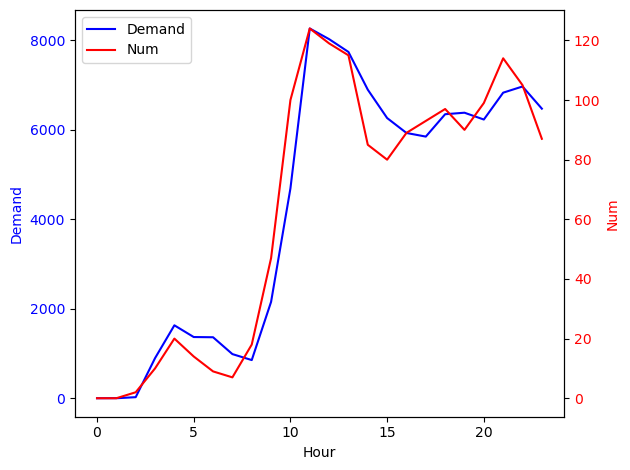

In [58]:
stations_demand_time = stations_demand.groupby("hour").agg(
    {"all_car_num": "sum", "charging_demand": "sum"}).reset_index()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设您已经有了一个名为 df 的 DataFrame，包含 "step"、"demand" 和 "num" 列

# 创建一个图形和一个坐标轴
fig, ax1 = plt.subplots()

# 插值方法
interp_method = 'cubic'  # 可以尝试不同的插值方法，如 'linear', 'quadratic', 'cubic'

# 绘制 "demand" 曲线
x = stations_demand_time['hour']
y_demand = stations_demand_time['charging_demand']
x_new = np.linspace(x.min(), x.max(), 300)  # 创建新的平滑的 x 值
y_demand_smooth = np.interp(x_new, x, y_demand)  # 进行插值计算
ax1.plot(x_new, y_demand_smooth, color='blue', label='Demand')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Demand', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建第二个坐标轴，并绘制 "num" 曲线
ax2 = ax1.twinx()
y_num = stations_demand_time['all_car_num']
y_num_smooth = np.interp(x_new, x, y_num)  # 进行插值计算
ax2.plot(x_new, y_num_smooth, color='red', label='Num')
ax2.set_ylabel('Num', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 添加图例
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')

# 调整布局，以便 "num" 的刻度显示在图的右边
fig.tight_layout()

plt.savefig('output/demands_24h.png')

# 显示图形
plt.show()

## 根据step可视化

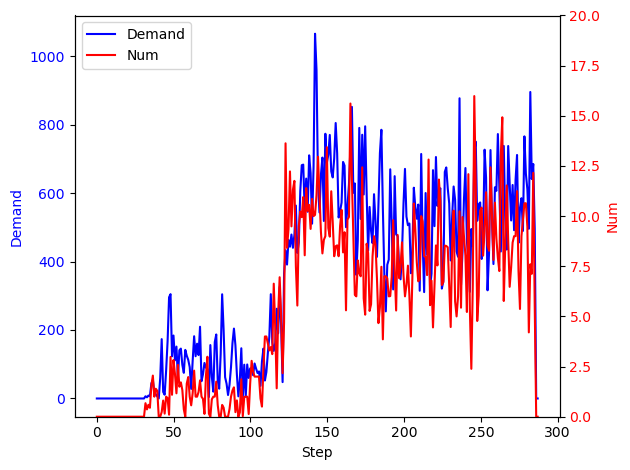

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设您已经有了一个名为 df 的 DataFrame，包含 "step"、"demand" 和 "num" 列

# 创建一个图形和一个坐标轴
fig, ax1 = plt.subplots()

# 插值方法
# interp_method = 'cubic'  # 可以尝试不同的插值方法，如 'linear', 'quadratic', 'cubic'
interp_method = 'quadratic'  # 可以尝试不同的插值方法，如 'linear', 'quadratic', 'cubic'

# 绘制 "demand" 曲线
x = stations_demand['step']
y_demand = stations_demand['charging_demand']
x_new = np.linspace(x.min(), x.max(), 300)  # 创建新的平滑的 x 值
y_demand_smooth = np.interp(x_new, x, y_demand)  # 进行插值计算
ax1.plot(x_new, y_demand_smooth, color='blue', label='Demand')
ax1.set_xlabel('Step')
ax1.set_ylabel('Demand', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 创建第二个坐标轴，并绘制 "num" 曲线
ax2 = ax1.twinx()
y_num = stations_demand['all_car_num']
y_num_smooth = np.interp(x_new, x, y_num)  # 进行插值计算
ax2.plot(x_new, y_num_smooth, color='red', label='Num')
ax2.set_ylabel('Num', color='red')
ax2.set_ylim([0, 20])  # 设置纵轴刻度范围
ax2.tick_params(axis='y', labelcolor='red')

# 添加图例
lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')

# 调整布局，以便 "num" 的刻度显示在图的右边
fig.tight_layout()

plt.savefig(f'output/qu_demands_{step_num + 1}step.png')

# 显示图形
plt.show()